In [1]:
import time
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as mpdf
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

from matplotlib.font_manager import FontProperties

### Функция вывода таблицы результатов по всем моделям

In [2]:
def print_results_report_table(model_results_list, model_results_headers):
    header_color = '#F2F2F2'
    df = pd.DataFrame(model_results_list)
    df.columns = model_results_headers

    fig, ax = plt.subplots(figsize=(5, 1))
    plt.axis('off')

    table = plt.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center',
        colWidths=[1.7, 0.6, 0.5])

    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 1.2)

    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor(header_color)
        else:
            cell.set_text_props(ha='center', va='center')

    plt.show()

### Функция вывода отчёта по количеству успешных/неуспешных попыток прогнозирования

In [3]:
def print_cross_class_report_table(y_true, y_pred):
    header_color = '#F2F2F2'
    table = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    table_np = np.array(table)

    fig, ax = plt.subplots(figsize=(8, 1))
    ax.axis('off')

    table = ax.table(cellText=table_np, cellLoc='center', rowLabels=table.index, colLabels=table.columns,
                     colWidths=[0.09] * len(table.columns),
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.2, 1.8)
        
    for (row, col), cell in table.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor(header_color)

    plt.show()

### Функция вывода отчёта точности обучения модели

In [4]:
def make_classification_report(labeler, y_true, y_pred):
    header_color = '#F2F2F2'
    true_labels = labeler.inverse_transform(y_true)
    predicted_labels = labeler.inverse_transform(y_pred)
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    
    macro_avg = round(report['macro avg']['recall'], 4)

    for key in report:
        if isinstance(report[key], dict):
            report[key] = {k: round(v, 3) for k, v in report[key].items()}
        else:
            report[key] = round(report[key], 4)

    protocol_keys = [key for key in report.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']]
    protocol_table_data = [['Protocol'] + list(report[protocol_keys[0]].keys())]
    for protocol in protocol_keys:
        row = [protocol] + list(report[protocol].values())
        protocol_table_data.append(row)

    average_keys = ['macro avg', 'weighted avg']
    average_table_data = [['Metrics'] + list(report[average_keys[0]].keys())]
    for average in average_keys:
        row = [average] + list(report[average].values())
        average_table_data.append(row)

    # Combine tables with an empty row
    combined_table_data = protocol_table_data + average_table_data

    # Plot the combined table
    fig, ax = plt.subplots(figsize=(8, 1))
    ax.axis('off')
    table = ax.table(cellText=combined_table_data, colLabels=None, cellLoc='center', loc='center')

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor(header_color)
        elif row == len(protocol_table_data):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor(header_color)

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.show()

    print_cross_class_report_table(true_labels, predicted_labels)
    
    return macro_avg

# Обработка и подготовка набора данных

In [5]:
### Загрузка и обработка набора данных

In [6]:
data = pd.read_csv('datasets/UNSW_NB15_training-set.csv')

count_per_protocol_type = data['proto'].value_counts()
protocols_to_remove = count_per_protocol_type[count_per_protocol_type < 100].index

data = data[~data['proto'].isin(protocols_to_remove)]

data = pd.get_dummies(data, columns=['state', 'service'])
data['attack_cat'] = data['attack_cat'].apply(lambda x: 0 if x == 'Normal' else 1)

print("Количество записей каждого протокола:")
for protocol, count in data['proto'].value_counts().items():
    print(f"{protocol:<20} {count}")

Количество записей каждого протокола:
tcp                  43095
udp                  29418
unas                 3515
arp                  987
ospf                 676
sctp                 324


### Разделение данных на обучающую и тестовую выборки

In [7]:
# Разделение на признаки и целевую переменную
features = data.drop('proto', axis=1)
target = data['proto']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.6, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Кодирование меток
labeler = LabelEncoder()
y_train_encoded = labeler.fit_transform(y_train)
y_test_encoded = labeler.transform(y_test)
    
print("Обучающая выборка: {} записей".format(len(X_train)))
print(y_train.value_counts())

print("Проверочная выборка: {} записей".format(len(X_test)))
print(y_test.value_counts())

model_results_list = []

Обучающая выборка: 31206 записей
proto
tcp     17157
udp     11847
unas     1420
arp       390
ospf      276
sctp      116
Name: count, dtype: int64
Проверочная выборка: 46809 записей
proto
tcp     25938
udp     17571
unas     2095
arp       597
ospf      400
sctp      208
Name: count, dtype: int64


# Тестирование различных алгоритмов и библиотек

### Логистическая регрессия (Scikit-learn)

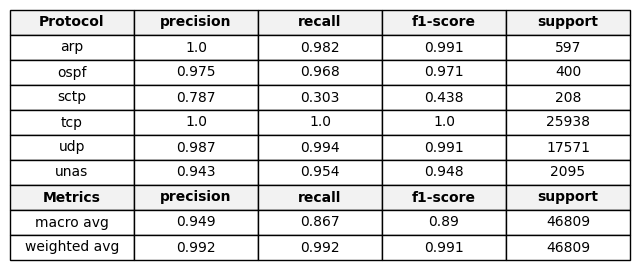

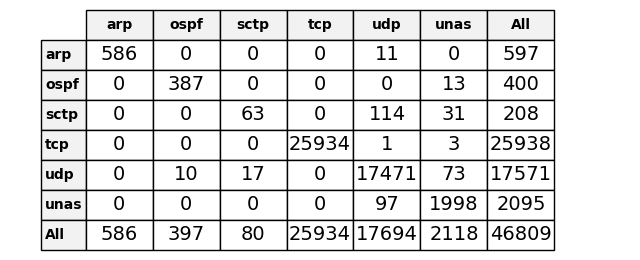

Время обучения: 155.16
Точность обучения: 0.8666


In [8]:
from sklearn.linear_model import LogisticRegression

model_name = "Логистическая регрессия (Scikit-learn)"

start_time = time.time()
model = LogisticRegression(solver='saga', max_iter=10000)
model.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

y_pred = model.predict(X_test_scaled)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Наивный бейесовский классификатор (Scikit-learn)

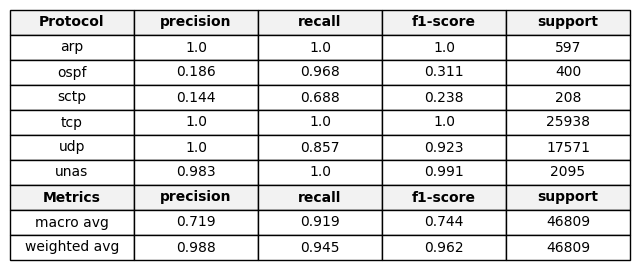

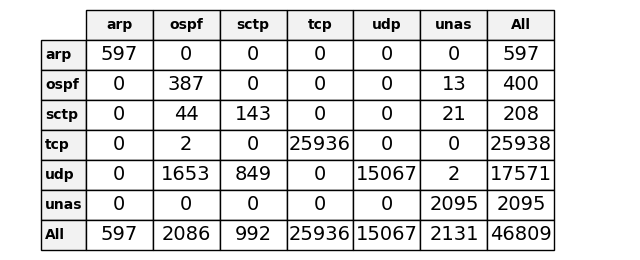

Время обучения: 0.02
Точность обучения: 0.9187


In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

model_name = "Наивный бейесовский классификатор (Scikit-learn)"

start_time = time.time()
model = GaussianNB()
model.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

y_pred = model.predict(X_test_scaled)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Наивный бейесовский классификатор (NLTK)

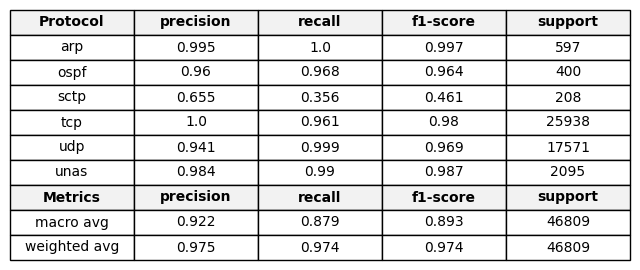

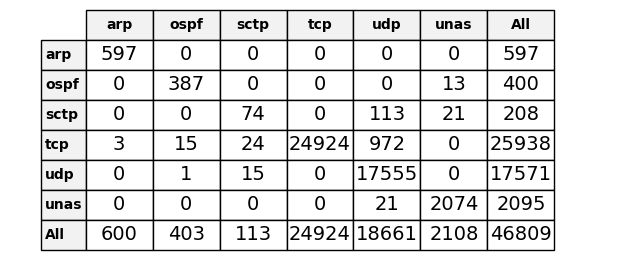

Время обучения: 1.08
Точность обучения: 0.8789


In [10]:
from nltk import NaiveBayesClassifier
from nltk.classify import accuracy

model_name = "Наивный бейесовский классификатор (NLTK)"

train_set = []
for i in range(len(X_train_scaled)):
    features_dict = dict(zip(range(len(X_train_scaled[i])), X_train_scaled[i]))
    label = y_train_encoded[i]
    train_set.append((features_dict, label))

test_set = []
for i in range(len(X_test_scaled)):
    features_dict = dict(zip(range(len(X_test_scaled[i])), X_test_scaled[i]))
    label = y_test_encoded[i]
    test_set.append((features_dict, label))

start_time = time.time()
classifier = NaiveBayesClassifier.train(train_set)
end_time = time.time()

y_pred = [classifier.classify(features_dict) for features_dict, _ in test_set]
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Метод опорных векторов (Scikit-learn)

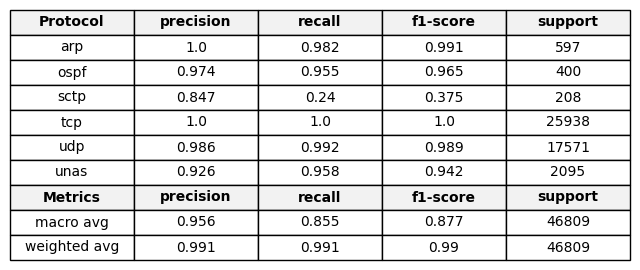

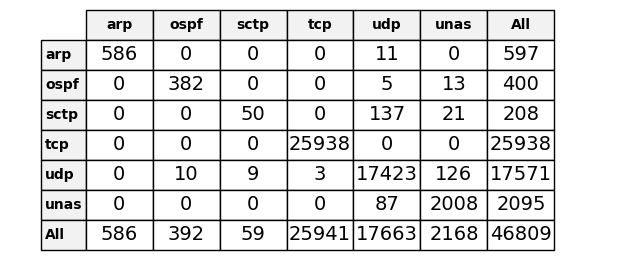

Время обучения: 1.98
Точность обучения: 0.8545


In [11]:
from sklearn.svm import SVC

model_name = "Метод опорных векторов (Scikit-learn)"

start_time = time.time()
model = SVC()
model.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

y_pred = model.predict(X_test_scaled)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Деревья принятия решений (Scikit-learn) (DecisionTreeClassifier)

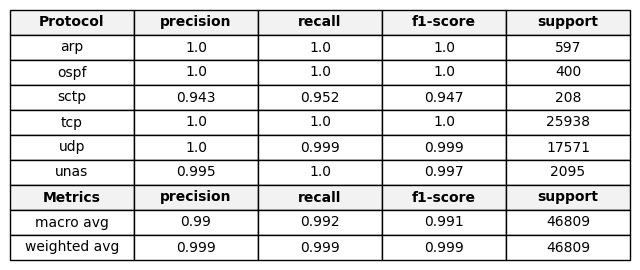

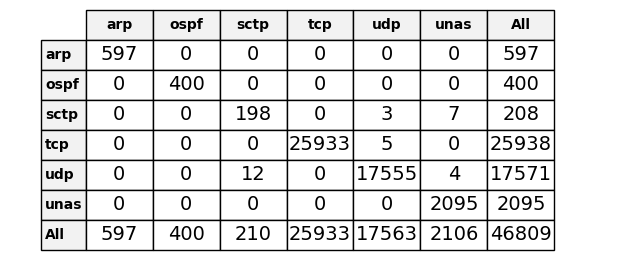

Время обучения: 0.08
Точность обучения: 0.9918


In [12]:
from sklearn.tree import DecisionTreeClassifier

model_name = "Деревья принятия решений (Scikit-learn.DecisionTreeClassifier)"

start_time = time.time()
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

y_pred = tree_clf.predict(X_test_scaled)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Бэггинг (Scikit-learn) (RandomForestClassifier)

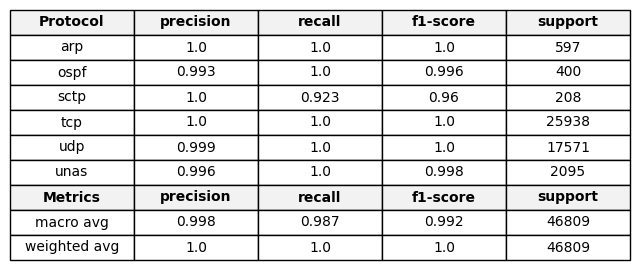

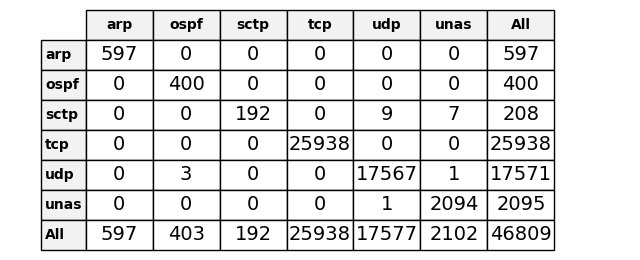

Время обучения: 8.1
Точность обучения: 0.9871


In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

model_name = "Бэггинг (Scikit-learn.RandomForestClassifier)"

start_time = time.time()
bagging_classifier = BaggingClassifier(estimator=RandomForestClassifier(), random_state=42)
bagging_classifier.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

y_pred = bagging_classifier.predict(X_test_scaled)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Бэггинг (XGBoost)

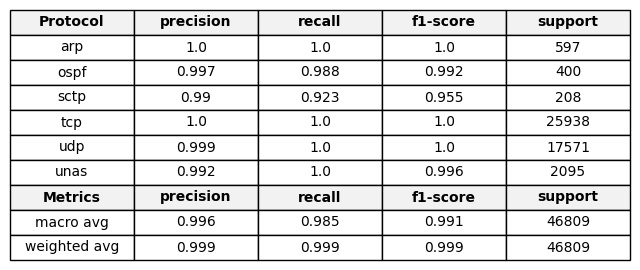

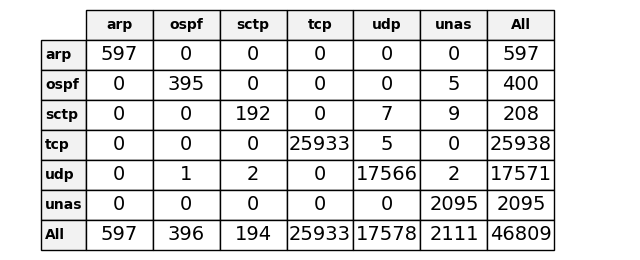

Время обучения: 23.58
Точность обучения: 0.985


In [14]:
from xgboost import XGBClassifier

model_name = "Бэггинг (XGBoost)"

start_time = time.time()
bagging_classifier = BaggingClassifier(estimator=XGBClassifier(), random_state=42)
bagging_classifier.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

y_pred = bagging_classifier.predict(X_test_scaled)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Бустинг (Scikit-learn) (GradientBoostingClassifier)

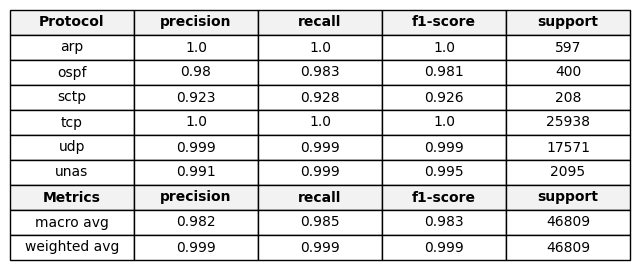

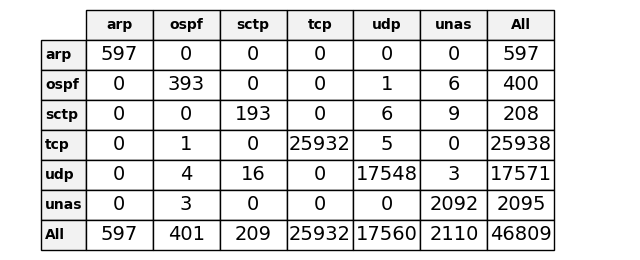

Время обучения: 71.92
Точность обучения: 0.9846


In [15]:
from sklearn.ensemble import GradientBoostingClassifier

model_name = "Бустинг (Scikit-learn.GradientBoostingClassifier)"

start_time = time.time()
clf = GradientBoostingClassifier()
clf.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

y_pred = clf.predict(X_test_scaled)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Бустинг (CatBoost)

Learning rate set to 0.094304
0:	learn: 1.3778024	total: 160ms	remaining: 2m 40s
1:	learn: 1.1251273	total: 173ms	remaining: 1m 26s
2:	learn: 0.9470278	total: 187ms	remaining: 1m 2s
3:	learn: 0.8126399	total: 201ms	remaining: 50s
4:	learn: 0.7051023	total: 215ms	remaining: 42.7s
5:	learn: 0.6181893	total: 229ms	remaining: 38s
6:	learn: 0.5457276	total: 244ms	remaining: 34.6s
7:	learn: 0.4846366	total: 258ms	remaining: 31.9s
8:	learn: 0.4330496	total: 272ms	remaining: 29.9s
9:	learn: 0.3867240	total: 285ms	remaining: 28.3s
10:	learn: 0.3470695	total: 301ms	remaining: 27.1s
11:	learn: 0.3127917	total: 315ms	remaining: 25.9s
12:	learn: 0.2826222	total: 330ms	remaining: 25s
13:	learn: 0.2557567	total: 344ms	remaining: 24.2s
14:	learn: 0.2326502	total: 358ms	remaining: 23.5s
15:	learn: 0.2114419	total: 373ms	remaining: 22.9s
16:	learn: 0.1930129	total: 388ms	remaining: 22.4s
17:	learn: 0.1761654	total: 402ms	remaining: 21.9s
18:	learn: 0.1609131	total: 416ms	remaining: 21.5s
19:	learn: 0.14

165:	learn: 0.0059376	total: 2.26s	remaining: 11.4s
166:	learn: 0.0059218	total: 2.27s	remaining: 11.3s
167:	learn: 0.0059036	total: 2.28s	remaining: 11.3s
168:	learn: 0.0058810	total: 2.29s	remaining: 11.3s
169:	learn: 0.0058554	total: 2.31s	remaining: 11.3s
170:	learn: 0.0058250	total: 2.31s	remaining: 11.2s
171:	learn: 0.0058006	total: 2.33s	remaining: 11.2s
172:	learn: 0.0057824	total: 2.34s	remaining: 11.2s
173:	learn: 0.0057686	total: 2.35s	remaining: 11.2s
174:	learn: 0.0057244	total: 2.36s	remaining: 11.1s
175:	learn: 0.0056932	total: 2.37s	remaining: 11.1s
176:	learn: 0.0056447	total: 2.39s	remaining: 11.1s
177:	learn: 0.0056239	total: 2.4s	remaining: 11.1s
178:	learn: 0.0056127	total: 2.41s	remaining: 11s
179:	learn: 0.0055294	total: 2.42s	remaining: 11s
180:	learn: 0.0055149	total: 2.43s	remaining: 11s
181:	learn: 0.0054870	total: 2.44s	remaining: 11s
182:	learn: 0.0054745	total: 2.45s	remaining: 11s
183:	learn: 0.0054468	total: 2.47s	remaining: 10.9s
184:	learn: 0.0053878	t

328:	learn: 0.0029156	total: 4.21s	remaining: 8.58s
329:	learn: 0.0029144	total: 4.22s	remaining: 8.56s
330:	learn: 0.0028913	total: 4.23s	remaining: 8.55s
331:	learn: 0.0028857	total: 4.24s	remaining: 8.53s
332:	learn: 0.0028530	total: 4.25s	remaining: 8.52s
333:	learn: 0.0028362	total: 4.27s	remaining: 8.51s
334:	learn: 0.0028297	total: 4.28s	remaining: 8.49s
335:	learn: 0.0028237	total: 4.29s	remaining: 8.47s
336:	learn: 0.0028139	total: 4.3s	remaining: 8.46s
337:	learn: 0.0028109	total: 4.31s	remaining: 8.44s
338:	learn: 0.0028020	total: 4.32s	remaining: 8.42s
339:	learn: 0.0027958	total: 4.33s	remaining: 8.41s
340:	learn: 0.0027876	total: 4.34s	remaining: 8.39s
341:	learn: 0.0027836	total: 4.35s	remaining: 8.38s
342:	learn: 0.0027769	total: 4.36s	remaining: 8.36s
343:	learn: 0.0027634	total: 4.38s	remaining: 8.34s
344:	learn: 0.0027608	total: 4.38s	remaining: 8.33s
345:	learn: 0.0027546	total: 4.39s	remaining: 8.31s
346:	learn: 0.0027475	total: 4.41s	remaining: 8.29s
347:	learn: 0

487:	learn: 0.0019109	total: 6.09s	remaining: 6.39s
488:	learn: 0.0019091	total: 6.11s	remaining: 6.38s
489:	learn: 0.0019072	total: 6.12s	remaining: 6.37s
490:	learn: 0.0019048	total: 6.13s	remaining: 6.35s
491:	learn: 0.0019031	total: 6.14s	remaining: 6.34s
492:	learn: 0.0018920	total: 6.15s	remaining: 6.33s
493:	learn: 0.0018815	total: 6.17s	remaining: 6.31s
494:	learn: 0.0018727	total: 6.18s	remaining: 6.3s
495:	learn: 0.0018679	total: 6.19s	remaining: 6.29s
496:	learn: 0.0018653	total: 6.2s	remaining: 6.28s
497:	learn: 0.0018634	total: 6.21s	remaining: 6.26s
498:	learn: 0.0018602	total: 6.22s	remaining: 6.25s
499:	learn: 0.0018576	total: 6.24s	remaining: 6.24s
500:	learn: 0.0018563	total: 6.25s	remaining: 6.22s
501:	learn: 0.0018540	total: 6.26s	remaining: 6.21s
502:	learn: 0.0018519	total: 6.27s	remaining: 6.19s
503:	learn: 0.0018477	total: 6.28s	remaining: 6.18s
504:	learn: 0.0018459	total: 6.29s	remaining: 6.17s
505:	learn: 0.0018435	total: 6.3s	remaining: 6.15s
506:	learn: 0.0

653:	learn: 0.0014840	total: 8s	remaining: 4.23s
654:	learn: 0.0014822	total: 8.01s	remaining: 4.22s
655:	learn: 0.0014810	total: 8.02s	remaining: 4.21s
656:	learn: 0.0014795	total: 8.04s	remaining: 4.19s
657:	learn: 0.0014772	total: 8.05s	remaining: 4.18s
658:	learn: 0.0014748	total: 8.06s	remaining: 4.17s
659:	learn: 0.0014678	total: 8.07s	remaining: 4.16s
660:	learn: 0.0014660	total: 8.08s	remaining: 4.14s
661:	learn: 0.0014639	total: 8.09s	remaining: 4.13s
662:	learn: 0.0014632	total: 8.1s	remaining: 4.12s
663:	learn: 0.0014624	total: 8.12s	remaining: 4.11s
664:	learn: 0.0014613	total: 8.13s	remaining: 4.09s
665:	learn: 0.0014601	total: 8.14s	remaining: 4.08s
666:	learn: 0.0014590	total: 8.15s	remaining: 4.07s
667:	learn: 0.0014537	total: 8.16s	remaining: 4.06s
668:	learn: 0.0014531	total: 8.18s	remaining: 4.04s
669:	learn: 0.0014498	total: 8.19s	remaining: 4.03s
670:	learn: 0.0014474	total: 8.2s	remaining: 4.02s
671:	learn: 0.0014468	total: 8.21s	remaining: 4.01s
672:	learn: 0.001

820:	learn: 0.0012498	total: 9.93s	remaining: 2.16s
821:	learn: 0.0012492	total: 9.94s	remaining: 2.15s
822:	learn: 0.0012484	total: 9.95s	remaining: 2.14s
823:	learn: 0.0012458	total: 9.96s	remaining: 2.13s
824:	learn: 0.0012449	total: 9.98s	remaining: 2.12s
825:	learn: 0.0012410	total: 9.99s	remaining: 2.1s
826:	learn: 0.0012406	total: 10s	remaining: 2.09s
827:	learn: 0.0012397	total: 10s	remaining: 2.08s
828:	learn: 0.0012384	total: 10s	remaining: 2.07s
829:	learn: 0.0012380	total: 10s	remaining: 2.06s
830:	learn: 0.0012375	total: 10s	remaining: 2.04s
831:	learn: 0.0012368	total: 10.1s	remaining: 2.03s
832:	learn: 0.0012353	total: 10.1s	remaining: 2.02s
833:	learn: 0.0012338	total: 10.1s	remaining: 2.01s
834:	learn: 0.0012329	total: 10.1s	remaining: 1.99s
835:	learn: 0.0012325	total: 10.1s	remaining: 1.98s
836:	learn: 0.0012320	total: 10.1s	remaining: 1.97s
837:	learn: 0.0012303	total: 10.1s	remaining: 1.96s
838:	learn: 0.0012299	total: 10.1s	remaining: 1.95s
839:	learn: 0.0012291	t

997:	learn: 0.0011117	total: 12s	remaining: 24.1ms
998:	learn: 0.0011106	total: 12s	remaining: 12ms
999:	learn: 0.0011092	total: 12s	remaining: 0us


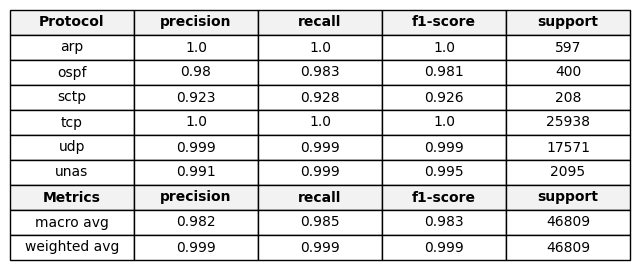

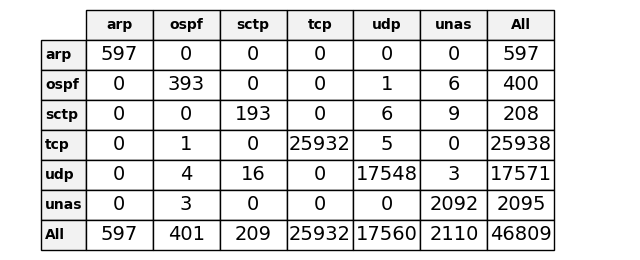

Время обучения: 12.24
Точность обучения: 0.9846


In [16]:
from catboost import CatBoostClassifier

model_name = "Бустинг (CatBoost)"

start_time = time.time()
clf = CatBoostClassifier()
clf.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

y_pred_encoded = clf.predict(X_test_scaled)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Нейронные сети (TensorFlow) (Convolutional Neural Networks)

Epoch 1/10
976/976 [==============================] - 2s 1ms/step - loss: 0.0684 - accuracy: 0.9799
Epoch 2/10
976/976 [==============================] - 1s 1ms/step - loss: 0.0301 - accuracy: 0.9906
Epoch 3/10
976/976 [==============================] - 1s 1ms/step - loss: 0.0241 - accuracy: 0.9922
Epoch 4/10
976/976 [==============================] - 1s 1ms/step - loss: 0.0216 - accuracy: 0.9937
Epoch 5/10
976/976 [==============================] - 1s 1ms/step - loss: 0.0212 - accuracy: 0.9935
Epoch 6/10
976/976 [==============================] - 1s 1ms/step - loss: 0.0192 - accuracy: 0.9942
Epoch 7/10
976/976 [==============================] - 1s 1ms/step - loss: 0.0193 - accuracy: 0.9946
Epoch 8/10
976/976 [==============================] - 1s 1ms/step - loss: 0.0171 - accuracy: 0.9945
Epoch 9/10
976/976 [==============================] - 1s 1ms/step - loss: 0.0157 - accuracy: 0.9950
Epoch 10/10
1463/1463 [==============================] - 1s 674us/step


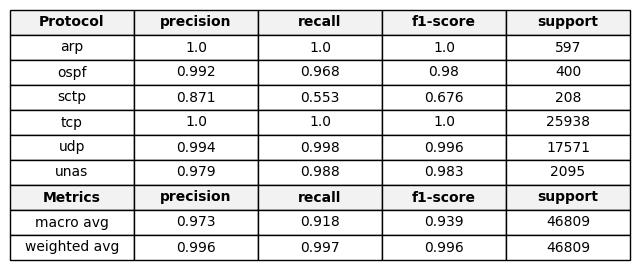

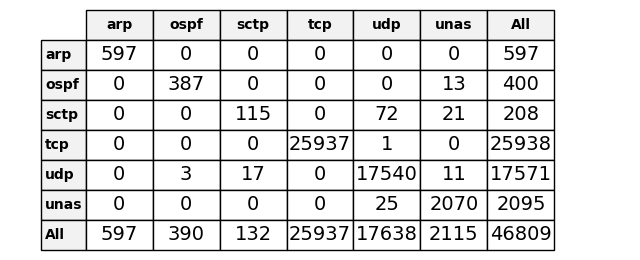

Время обучения: 12.21
Точность обучения: 0.9178


In [17]:
model_name = "Нейронные сети (TensorFlow) (CNN)"

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(labeler.classes_), activation='softmax')
])

start_time = time.time()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=32)
end_time = time.time()

y_pred_prob = model.predict(X_test_reshaped)
y_pred = y_pred_prob.argmax(axis=1)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Нейронные сети (TensorFlow) (Recurrent Neural Networks)

Epoch 1/10
976/976 [==============================] - 3s 3ms/step - loss: 0.1443 - accuracy: 0.9614
Epoch 2/10
976/976 [==============================] - 3s 3ms/step - loss: 0.0521 - accuracy: 0.9842
Epoch 3/10
976/976 [==============================] - 3s 3ms/step - loss: 0.0423 - accuracy: 0.9866
Epoch 4/10
976/976 [==============================] - 3s 3ms/step - loss: 0.0391 - accuracy: 0.9890
Epoch 5/10
976/976 [==============================] - 3s 3ms/step - loss: 0.0360 - accuracy: 0.9887
Epoch 6/10
976/976 [==============================] - 3s 3ms/step - loss: 0.0323 - accuracy: 0.9908
Epoch 7/10
976/976 [==============================] - 3s 3ms/step - loss: 0.0337 - accuracy: 0.9897
Epoch 8/10
976/976 [==============================] - 3s 3ms/step - loss: 0.0348 - accuracy: 0.9900
Epoch 9/10
976/976 [==============================] - 3s 3ms/step - loss: 0.0291 - accuracy: 0.9917
Epoch 10/10
1463/1463 [==============================] - 2s 1ms/step


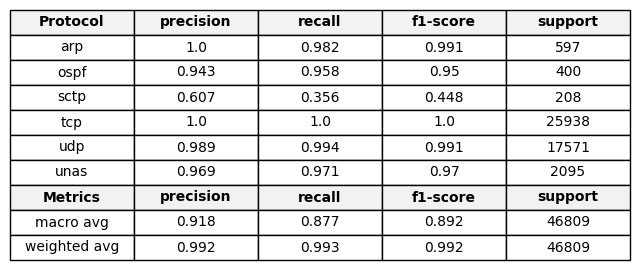

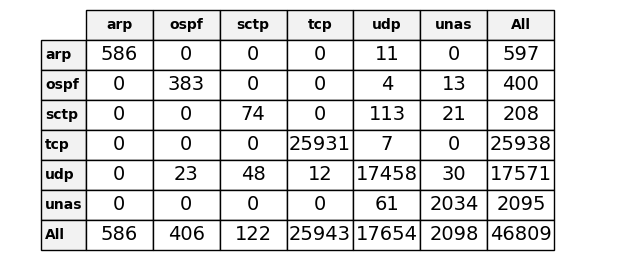

Время обучения: 28.26
Точность обучения: 0.8765


In [18]:
model_name = "Нейронные сети (TensorFlow) (RNN)"

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=(X_train_reshaped.shape[1], 1)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(labeler.classes_), activation='softmax')
])

start_time = time.time()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=32)
end_time = time.time()

y_pred_prob = model.predict(X_test_reshaped)
y_pred = y_pred_prob.argmax(axis=1)
model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

### Нейронные сети (PyTorch)

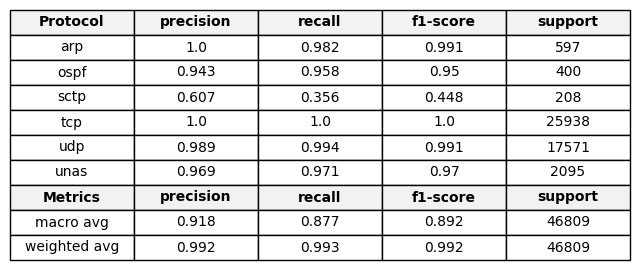

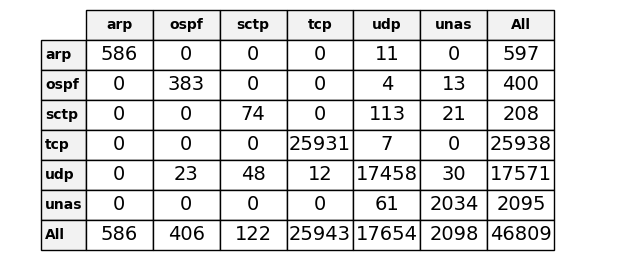

Время обучения: 4.57
Точность обучения: 0.8765


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

model_name = "Нейронные сети (PyTorch)"

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Define the Neural Network model
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X_train_scaled.shape[1]
num_classes = len(labeler.classes_)

model = Net(input_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 10
batch_size = 32
total_samples = X_train_tensor.shape[0]
total_batches = total_samples // batch_size

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(total_batches):
        # Prepare batch
        start = i * batch_size
        end = start + batch_size
        batch_X = X_train_tensor[start:end]
        batch_y = y_train_tensor[start:end]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
end_time = time.time()

# Evaluation
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

model_result = {
    'name': model_name,
    'speed': round(end_time - start_time, 2),
    'accuracy': make_classification_report(labeler, y_test_encoded, y_pred)
}
model_results_list.append(model_result)

print(f"Время обучения: {model_result['speed']}")
print(f"Точность обучения: {model_result['accuracy']}")

In [20]:
# Анализ результатов

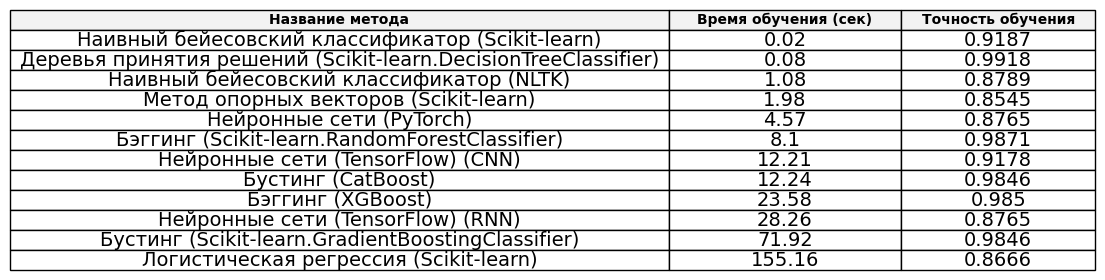

In [21]:
model_results_headers = ['Название метода', 'Время обучения (сек)', 'Точность обучения']
fastest_training_speed = sorted(model_results_list, key=lambda x: x['speed'])
print_results_report_table(fastest_training_speed, model_results_headers)

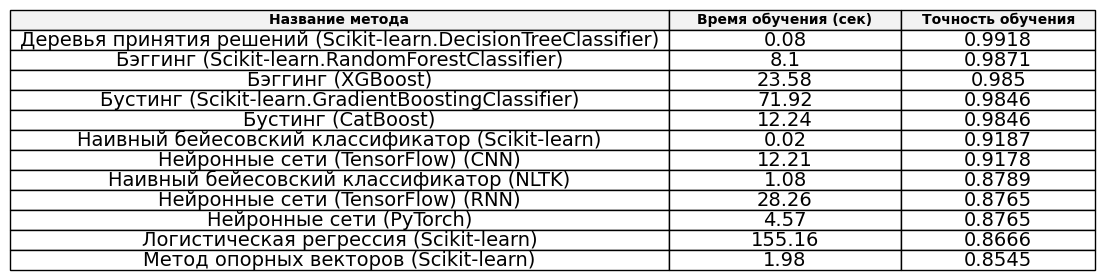

In [22]:
most_accurate_training = sorted(model_results_list, key=lambda x: x['accuracy'], reverse=True)
print_results_report_table(most_accurate_training, model_results_headers)

In [1]:
print(model_results_list)

NameError: name 'model_results_list' is not defined